In [1]:
import numpy as np
import astropy.io.fits
import matplotlib.pyplot as plt
import scipy as sym 
import scipy.integrate as integrate
from scipy import log,exp,sqrt,stats
from astropy import units as u
import astropy.constants as const
from scipy.optimize import curve_fit
from astropy.stats import biweight_location, biweight_scale, bootstrap
from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.interpolate import interp1d
import scipy.stats as stats
from astropy.stats import sigma_clip
c=const.c.to("km/s")
%matplotlib inline
cosmos = LambdaCDM(H0=67.77* u.km / u.Mpc / u.s, Om0=0.307115, Ode0=0.692885)  # define cosmology on the basis of simulation

In [2]:
from astropy.table import Column, Table

path_2_data = 'halodir_047_0000.fit'
print('opening', path_2_data)
my_file=Table.read(path_2_data)
print(my_file.info()) #[1].data.columns)
data = my_file#[1].data

opening halodir_047_0000.fit
<Table length=19174>
        name         dtype       unit     
------------------- ------- --------------
              M200c float64               
              M500c float64               
               Macc float64               
              Mpeak float64               
        Mpeak_Scale float64               
               Mvir float64               
           Mvir_all float64               
          Rs_Klypin float64               
               Rvir float64               
               Spin float64               
       Spin_Bullock float64               
                T_U float64               
         Vmax_Mpeak float64               
               Voff float64               
              Vpeak float64               
               Xoff float64               
             b_to_a float64               
        b_to_a_500c float64               
             c_to_a float64               
        c_to_a_500c float64               
    

In [3]:
# Clusters ra , dec  and z
subhaloes = data.field('pid')>=0
z   = data.field('redshift_R')[subhaloes] # 
ra  = data.field('RA')        [subhaloes] #* (np.pi/180) # degrees
dec = data.field('DEC')       [subhaloes] # * (np.pi/180) # degrees
"R_cl the virial radius of the cluster"
print(len(z), 'subhaloes')

3673 subhaloes


In [4]:
z.min(),z.max()

(0.06886010747978265, 0.11635218029319655)

In [5]:
D_cl=cosmos.comoving_distance(z)
d_C = D_cl
dc_mpc = (d_C).value
dc_interpolation = interp1d(z, dc_mpc)
z_interpolation = interp1d(dc_mpc, z)
def get_x_y_z(ra_radian, dec_radian, rr):
    phi   = ( ra_radian   - 180 ) * np.pi / 180.
    theta = (dec_radian + 90 ) * np.pi / 180.
    xx = rr * np.cos( phi) * np.sin( theta )
    yy = rr * np.sin( phi) * np.sin( theta )
    zz = rr * np.cos( theta )
    return xx, yy, zz

xx, yy, zz = get_x_y_z(ra, dec, dc_interpolation(z))


In [6]:
#Applying the mask"mask =np.where(data.RA<42.50)
sel_clusters = (data.field('M200c')>1e13 ) & ( data.field('M200c')<1e15) & (data.field('pid')==-1)
id_clusters = np.hstack(( np.argwhere( (data.field('M200c')>2e13 ) & ( data.field('M200c')<1e15) & (data.field('pid')==-1) ) ))
print(sel_clusters, len(sel_clusters.nonzero()[0]), id_clusters)
# Cluster ra and dec
#print(z_cl, r_cl)


[False False False ... False False False] 21 [ 5720  5737  5755  5756  5761  5765  9774  9779  9956 10020 10027 10031]


In [7]:
distances, angular_distances, id_galaxies, distinct_z, distinct_r = [], [], [], [], []
for id_cluster in np.arange(len(data))[sel_clusters]:
    ra_cl=data.field('RA')[id_cluster]
    dec_cl=data.field('DEC')[id_cluster]
    z_cl=data.field('redshift_R')[id_cluster]
    r_cl= data.field('Rvir')[id_cluster]
    # get 3D Cartesian positions of the sub haloes
    #print('x mean, std',np.mean(data.field('x[mask]')-xx), np.std(data.field('x[mask]')-xx))
    ##print('x mean, std',np.mean(data.field('y')-yy), np.std(data.field('y')-yy))
    #print('x mean, std',np.mean(data.field('z')-zz), np.std(data.field('z')-zz))
    # get 3D Cartesian positions of the cluster
    xx_cl, yy_cl, zz_cl = get_x_y_z(ra_cl, dec_cl, dc_interpolation(z_cl))
    #print('ra,dec,z=',ra_cl, dec_cl, z_cl, '\n x,y,z=',xx_cl, yy_cl, zz_cl)
    # array of distances between sub haloes and the cluster : 
    DX = np.sqrt((xx_cl-xx)**2 + (yy_cl-yy)**2 + (zz_cl-zz)**2)
    withinR = DX <= r_cl/1000.
    id_galaxies .append( np.arange(len(ra))[withinR] )
    distances .append( DX[withinR]/(r_cl/1000.) )
    # angular distances
    coordinates_SubHaloes = SkyCoord( ra, dec, unit='deg', frame='icrs') 
    coordinate_cluster    = SkyCoord( ra_cl , dec_cl, unit='deg', frame='icrs') 
    Angular_separation_Astropy = coordinates_SubHaloes.separation( coordinate_cluster )
    Angular_separation_Astropy_radian = (Angular_separation_Astropy).to(u.radian)[withinR]
    angular_distances.append(Angular_separation_Astropy_radian)  
    distinct_z.append( z_cl*np.ones_like(Angular_separation_Astropy_radian) )
    distinct_r.append( r_cl*np.ones_like(Angular_separation_Astropy_radian) )
    #print(distances)
distances = np.hstack(( distances ))
angular_distances = np.hstack(( angular_distances ))
id_galaxies = np.hstack(( id_galaxies ))
distinct_z = np.hstack(( distinct_z ))
distinct_r = np.hstack(( distinct_r ))
print(len(distances), id_galaxies)


1013 [  35   36   60 ... 1908 2579 3107]


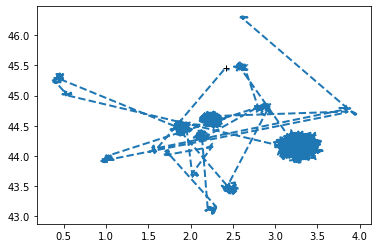

In [8]:
plt.plot(dec[id_galaxies].value,ra[id_galaxies].value,linestyle='dashed', linewidth = 2)
plt.plot(dec_cl,ra_cl,c='k',linestyle='dashed', linewidth = 2, marker='+', markerfacecolor='green', )

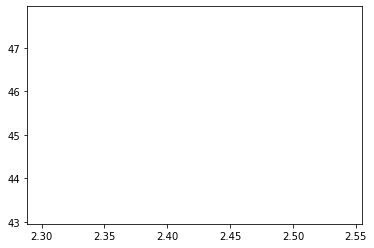

In [9]:
plt.plot(dec_cl,ra_cl,color='red')

In [10]:
distinct_r = np.hstack(( distinct_r ))

r_3d = np.array(distances)/(distinct_r.value/1000.)
print(r_3d.min(), r_3d.max(), distinct_r.max().value/1000.)

r_proj = (angular_distances * cosmos.angular_diameter_distance(distinct_z)/u.radian  ).value * r_3d
print(r_proj, distances, r_proj< distances, distinct_r.value)
N_subhaloes = len(r_proj)

0.0 2.0307962796494587 1.74958
[0.52895084 0.22317102 0.00229973 ... 0.41624694 0.38453369 0.31678606] [0.85035279 0.59754743 0.05059407 ... 0.68731822 0.96012857 0.5901352 ] [ True  True  True ...  True  True  True] [583.388 583.388 583.388 ... 502.64  502.64  502.64 ]


In [11]:
distances.max(),r_proj.max()

(0.9984266542268178, 0.9225479035220675)

In [12]:
# create histogram of distances in Mpc

def get_bins(r_proj, N_per_bin=20):
    dR=0.0001
    r_bins_fine = np.arange(0., 2.5, dR)
    # Projected distance
    N_2D_fine, bins_2D_fine = np.histogram(np.array(r_proj), bins = r_bins_fine)
    R_2D_fine = (bins_2D_fine[1:] + bins_2D_fine[:-1])/2.
    #rint( np.cumsum( N_2D_fine) )
    itp_bins = interp1d(np.cumsum( N_2D_fine), R_2D_fine )
    #rint(itp_bins(np.arange(N_per_bin, N_subhaloes, N_per_bin)))
    bins_2D = np.hstack((0., itp_bins(np.arange(N_per_bin, N_subhaloes, N_per_bin)), 2.5 ))
    #rint(bins_2D)
    return bins_2D
    # Three D distance
    #N_3D, bins_3D = np.histogram(np.array(distances[mask]), bins = r_bins)


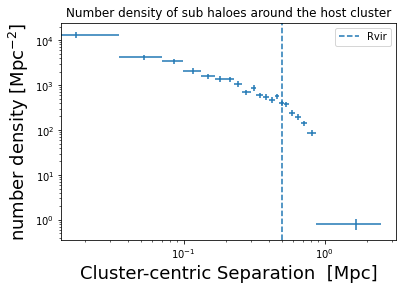

In [13]:
bins_2D = get_bins(r_proj, N_per_bin=50)

#dR=0.1
#r_bins = np.arange(0., r_cl/1000.+dR,dR)
# Projected distance
N_2D, bins_2D = np.histogram(np.array(r_proj), bins = bins_2D)

#Getting the number density profile in 2D 
R_2D = (bins_2D[1:] + bins_2D[:-1])/2.
n_2D = N_2D /(np.pi*( ( bins_2D[1:]**2 - bins_2D[:-1]**2) ) )
dR_2D = [ bins_2D[1:] - R_2D, R_2D - bins_2D[:-1] ]
# central point of each separation 

#plt.plot(R_2D, n_2D, color='black', linestyle='dashed', linewidth = 2, marker='o', markerfacecolor='green', markersize=12)
plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR_2D, ls='')
plt.yscale('log')
plt.xscale('log')
plt.title('Number density of sub haloes around the host cluster')
plt.xlabel('Cluster-centric Separation  [Mpc]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-2}$]',fontsize=18) 
plt.axvline(x=r_cl/1000.,linestyle='dashed',label = 'Rvir')
plt.legend(loc=1, numpoints=1)
plt.show()

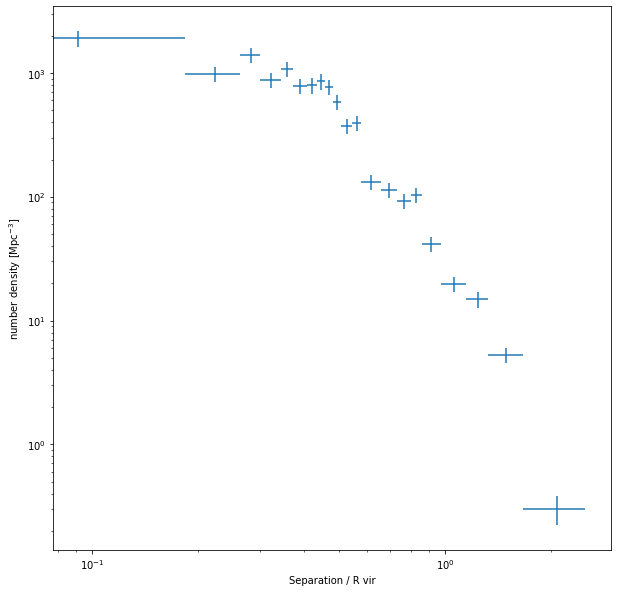

In [14]:
# Three D distance
bins_3D = get_bins(r_3d, N_per_bin=50)
N_3D, bins_3D = np.histogram(r_3d, bins = bins_3D)

R_3D = (bins_3D[1:] + bins_3D[:-1])/2.
dR_3D = [ bins_3D[1:] - R_3D, R_3D - bins_3D[:-1] ]

#Ns,rs=np.histogram(r)
number_density = N_3D/(np.pi*( 4* ( bins_3D[1:]**3-bins_3D[:-1]**3) / 3))

r_act = (bins_3D[1:] + bins_3D[:-1])/2.
#plt.xscale('log')
#plt.yscale('log')
plt.figure(0, (10, 10))

plt.errorbar(r_act, number_density, xerr=dR_3D, ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')
#plt.plot(r_act, number_density, color='black', linestyle='dashed', linewidth = 2, marker='o', markerfacecolor='green', markersize=12)
plt.xlabel('Separation / R vir')
plt.ylabel(r'number density [Mpc$^{-3}$]')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [15]:
r_array=np.arange(distances.min(),distances.max(),0.01)
r_array

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [16]:
"""
The interplation of dndR for solving the integral first of all 
Stacking the Proj and dndR

""" 
#Getting the derivative term of n wrt R_proj  ie dndR
dndR = np.array(np.gradient(n_2D,R_2D))
n_2D_no0 = N_2D
n_2D_no0[N_2D==0] = 1

dndR_up = np.array(np.gradient( n_2D + n_2D * n_2D_no0**-0.5, R_2D ))
dndR_low = np.array(np.gradient( n_2D - n_2D * n_2D_no0**-0.5, R_2D ))

def get_nu_all(dndR):
    xx = np.hstack((np.array([0]),np.array(R_2D), np.array([10.]) ))
    yy = np.hstack((np.array(dndR[0]),np.array(dndR), np.array([0.]) ))

    # getting the interpolation
    inter1 = interp1d(xx, yy, bounds_error=True)

    # De-projection of the number density profile from 
    # 2D to 3D using the Abel inversion equation

    def nu(R_2D, r):
        """
        Latex equation
        Reference to the article it comes from
        """
        
        return (-1/(np.pi))*(inter1(R_2D)/((R_2D**2 - r**2)**0.5))

    nu_all=[integrate.quad(nu, r_i, 10, args=(r_i))[0] for r_i in r_array]
    return nu_all

nu_all = get_nu_all(dndR)
nu_all_up = get_nu_all(dndR_up)
nu_all_low = get_nu_all(dndR_low)



/tmp/ipykernel_11845/329480443.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  nu_all=[integrate.quad(nu, r_i, 10, args=(r_i))[0] for r_i in r_array]
/tmp/ipykernel_11845/329480443.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  nu_all=[integrate.quad(nu, r_i, 10, args=(r_i))[0] for r_i in r_array]


In [17]:
data.field('rs').max()

444.016

/home/atul/anaconda3/lib/python3.9/site-packages/colossus/halo/profile_nfw.py:188: RuntimeWarning: divide by zero encountered in true_divide
  return rhos / x / (1.0 + x)**2
/home/atul/anaconda3/lib/python3.9/site-packages/colossus/halo/profile_nfw.py:188: RuntimeWarning: divide by zero encountered in true_divide
  return rhos / x / (1.0 + x)**2


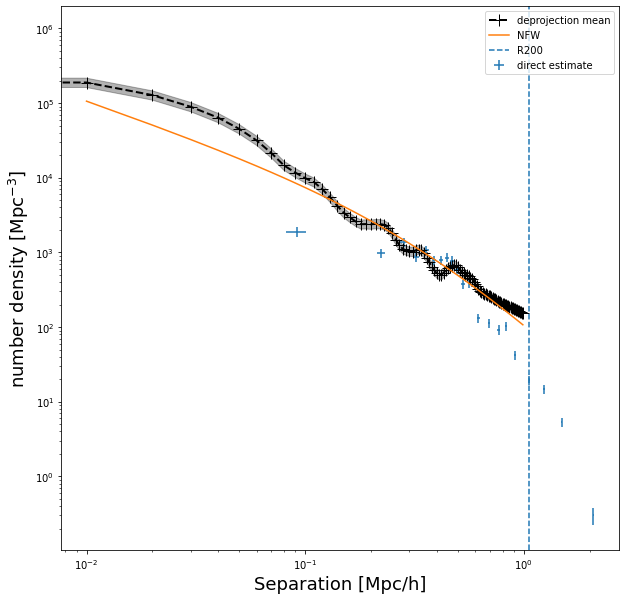

In [18]:
# plotting the de-projected number density wrt actual distance from the cluster center


# Nfw parameters modelling 
from colossus.halo import profile_nfw
# Parameters
Rs=0.444
rhos = 2500.0
# Nfw as function of actual radius of the cluster
p_nfw = profile_nfw.NFWProfile(rhos , Rs)

rho_nfw = p_nfw.density(r_array)
# Plotting the function 
plt.figure(0, (10, 10))

# Plotting  the de-projected number density
plt.plot(r_array, nu_all, label='deprojection mean', c='k',linestyle='dashed', linewidth = 2, marker='+', markerfacecolor='green', markersize=12)
plt.fill_between(r_array, y1=nu_all_low, y2=nu_all_up, alpha=0.3, color='k')

# Direct estimate error bars / Actual density
plt.errorbar(r_act, number_density, xerr=0.01/1.059, ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')
#plt.errorbar(r_act, number_density*2*np.pi, xerr=0.01/1.059, ls='', yerr=number_density * N_3D**-0.5)

# Modelling with NFW
plt.plot(r_array,rho_nfw , label = 'NFW');
rho_nfw = p_nfw.density(r_array)
# axis
plt.xlabel('Separation [Mpc/h]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-3}$]',fontsize=18)

# r200
plt.axvline(x=1.059,linestyle='dashed',label = 'R200')

# Log scale
#plt.ylim((1e2, 1e6))
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=1, numpoints=1)

In [19]:
np.sort(c*z)

<Quantity [20643.74087951, 20653.64692719, 20675.33620242, ...,
           34875.9898815 , 34880.22802778, 34881.50612376] km / s>

In [20]:
(c*z)-c*z_cl

<Quantity [ 1863.49005936,  2099.32952721,  6867.06136092, ...,
           -6294.42973295, -5361.76009066, -5418.93734911] km / s>